## Librerías

In [ ]:
import os
import shutil
import subprocess
import numpy as np
import pandas as pd
import scipy.io
import random
from PIL import Image
from copy import copy, deepcopy
from IPython.display import display

import matplotlib.pyplot as plt

from os import listdir
from os.path import join
from tqdm.notebook import tqdm
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split

import torchvision.models as models
import torchvision.transforms as transforms

from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision.models import ResNeXt101_64X4D_Weights

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


## Load Dataset

In [ ]:
repo_url = 'https://github.com/brendenlake/omniglot.git'
subprocess.call(['git', 'clone', repo_url])

0

In [ ]:
!unzip -qq './omniglot/python/images_background.zip'
!unzip -qq './omniglot/python/strokes_background.zip'

## Orden de las imágenes

En la carpeta images_background, hay 30 alfabetos diferentes. Cada alfabeto contiene una cantidad variada de caracteres, entre 20-50 aprox. Cada uno de los caracteres cuenta es de la forma XXXX_YY.png, donde XXXX corresponde al identificador del caracter, el cual es único entre todos los caracteres de todos los alfabetos. YY corresponde al número de muestra de un caracter en específico, el cual va siempre desde 01 hasta 20 (20 muestras por caracter).

Ahora bien, el problema está en que los XXXX no vienen ordenados secuencialmente en cada uno de los alfabetos. Por lo tanto, para hacer el preprocesamiento, hará un diccionario que mapeará cada uno de los id a un valor ordenado, para que la posterior clasificación sea más rápida.

In [ ]:
img_dir = 'images_background'
# stroke_dir = 'strokes_background'
nreps = 20 # number of renditions for each character
# nalpha = 5 # number of alphabets to show

alphabet_names = sorted([a for a in os.listdir(img_dir) if a[0] != '.']) # get folder names
length_alphabet_names = len(alphabet_names)
character_lengths = [len(os.listdir(os.path.join(img_dir, alph_name))) for alph_name in alphabet_names]

# alphabet_names = random.sample(alphabet_names,nalpha) # choose random alphabets
# print(len(alphabet_names))

N = sum([len(os.listdir(os.path.join(img_dir, alph_name, char)))
            for alph_name in alphabet_names
            for char in os.listdir(os.path.join(img_dir, alph_name))
      ])


y = np.zeros((N), 'int') # ground truth
current_character_folder = 0 # carpeta de un caracter visitado

df_alphabet_names = []
df_character_names = []
df_character_idx = []
df_paths = []
df_y = []

for i in range(len(alphabet_names)):
  alphabet_name = alphabet_names[i]
  character_length = character_lengths[i]
  character_folders = sorted(os.listdir(os.path.join(img_dir, alphabet_name)))

  for j in range(character_length):
    character_folder = character_folders[j]
    characters = sorted(os.listdir(os.path.join(img_dir, alphabet_name, character_folder)))
    # print(character_folder)

    for k in range(nreps):
      y[(current_character_folder * nreps) + k] = current_character_folder

      # Se añade al Df
      df_alphabet_names.extend([alphabet_name])
      df_character_names.extend([character_folder])
      df_character_idx.extend([k])
      df_paths.extend([os.path.join(img_dir, alphabet_name, character_folder, characters[k])])
      df_y.extend([current_character_folder])

    current_character_folder += 1


df = pd.DataFrame({
    'Alphabet': df_alphabet_names,
    'Character': df_character_names,
    'Sample': df_character_idx,
    'Path': df_paths,
    'y': df_y
})

Al observar las muestras que tenemos, se obtiene lo siguiente

In [ ]:
df

,Alphabet,Character,Sample,Path,y
0,Alphabet_of_the_Magi,character01,0,images_background/Alphabet_of_the_Magi/charact...,0
1,Alphabet_of_the_Magi,character01,1,images_background/Alphabet_of_the_Magi/charact...,0
2,Alphabet_of_the_Magi,character01,2,images_background/Alphabet_of_the_Magi/charact...,0
3,Alphabet_of_the_Magi,character01,3,images_background/Alphabet_of_the_Magi/charact...,0
4,Alphabet_of_the_Magi,character01,4,images_background/Alphabet_of_the_Magi/charact...,0
...,...,...,...,...,...
19275,Tifinagh,character55,15,images_background/Tifinagh/character55/0964_16...,963
19276,Tifinagh,character55,16,images_background/Tifinagh/character55/0964_17...,963
19277,Tifinagh,character55,17,images_background/Tifinagh/character55/0964_18...,963
19278,Tifinagh,character55,18,images_background/Tifinagh/character55/0964_19...,963


## Ejemplo de una imagen

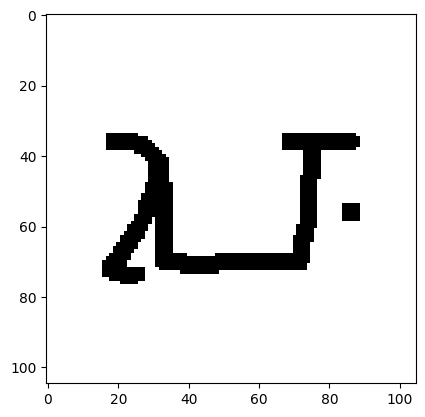

In [ ]:
path = df.iloc[0]['Path']
img = Image.open(path)
# print('Shape:', img.shape)
plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
print(img)

<PIL.PngImagePlugin.PngImageFile image mode=1 size=105x105 at 0x7F61F9D5EE30>


## Separación Train - Val - Test:

El objetivo de la ResNet es justamente clasificar cada uno de los caracteres. En total, tenemos 964 caracteres distintos (labels enumerados del 0 al 963), provenientes de 30 alfabetos, y cada caracter posee 20 muestras. Por ende, tenemos 19280 imagenes distintas.

Dado que cada caracter posee 20 muestras, se utilizará una proporción 70% train, 20% validation y 10% test. Vale decir: 14 imágenes de train, 4 de validation, y 2 de test por cada caracter.

En total debería dar:
* 13.496 imágenes de Train
* 3.856 imágenes de Validation
* 1.928 imágenes de Test

In [ ]:
# Separacion de df basados en el numero de fila
df_train = df.groupby('y').head(14)
df_val = df.groupby('y').apply(lambda x: x.iloc[14:18])
df_test = df.groupby('y').apply(lambda x: x.iloc[18:20])

# Reseteamos los indices de los df
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)


In [ ]:
print('Length df_train:', len(df_train))
print('Length df_val:', len(df_val))
print('Length df_test:', len(df_test))

Length df_train: 13496
Length df_val: 3856
Length df_test: 1928


Por ejemplo, si vemos como quedó el df_train:

In [ ]:
df_train[0:20]

,Alphabet,Character,Sample,Path,y
0,Alphabet_of_the_Magi,character01,0,images_background/Alphabet_of_the_Magi/charact...,0
1,Alphabet_of_the_Magi,character01,1,images_background/Alphabet_of_the_Magi/charact...,0
2,Alphabet_of_the_Magi,character01,2,images_background/Alphabet_of_the_Magi/charact...,0
3,Alphabet_of_the_Magi,character01,3,images_background/Alphabet_of_the_Magi/charact...,0
4,Alphabet_of_the_Magi,character01,4,images_background/Alphabet_of_the_Magi/charact...,0
5,Alphabet_of_the_Magi,character01,5,images_background/Alphabet_of_the_Magi/charact...,0
6,Alphabet_of_the_Magi,character01,6,images_background/Alphabet_of_the_Magi/charact...,0
7,Alphabet_of_the_Magi,character01,7,images_background/Alphabet_of_the_Magi/charact...,0
8,Alphabet_of_the_Magi,character01,8,images_background/Alphabet_of_the_Magi/charact...,0
9,Alphabet_of_the_Magi,character01,9,images_background/Alphabet_of_the_Magi/charact...,0


## Modelo ResNeXt

In [ ]:
num_classes = 964 # Cantidad de clases que hay

In [ ]:
model = models.resnext101_64x4d(weights=ResNeXt101_64X4D_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(2048, num_classes, bias=True)
model.aux_logits=False
model.to(device)

for param in model.parameters(): param.requires_grad = False

# Descongelamos la última capa
for param in model.fc.parameters(): param.requires_grad = True

summary(model, input_size=(3, 105, 105))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.7)

Downloading: "https://download.pytorch.org/models/resnext101_64x4d-173b62eb.pth" to /root/.cache/torch/hub/checkpoints/resnext101_64x4d-173b62eb.pth
100%|██████████| 319M/319M [00:05<00:00, 61.6MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 53, 53]           9,408
       BatchNorm2d-2           [-1, 64, 53, 53]             128
              ReLU-3           [-1, 64, 53, 53]               0
         MaxPool2d-4           [-1, 64, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]          16,384
       BatchNorm2d-6          [-1, 256, 27, 27]             512
              ReLU-7          [-1, 256, 27, 27]               0
            Conv2d-8          [-1, 256, 27, 27]           9,216
       BatchNorm2d-9          [-1, 256, 27, 27]             512
             ReLU-10          [-1, 256, 27, 27]               0
           Conv2d-11          [-1, 256, 27, 27]          65,536
      BatchNorm2d-12          [-1, 256, 27, 27]             512
           Conv2d-13          [-1, 256, 27, 27]          16,384
      BatchNorm2d-14          [-1, 256,

## Train

In [ ]:
class Character(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.transform = transform
        self.images = images     # Vincula el indice con un nombre de archivo
        self.labels = labels     # Vincula el indice con una clase

    def get_image(self, path):
        # img = plt.imread(path)
        img = Image.open(path)
        return img

    def __getitem__(self, idx):
        path_name = self.images[idx]
        label = self.labels[idx]
        img = self.get_image(path_name)

        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.images)

In [ ]:
# Set up data transformations
transform = Compose([
    lambda x: x.convert('RGB'),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_dataset = Character(images=df_train['Path'], labels=df_train['y'], transform=transform)
val_dataset = Character(images=df_val['Path'], labels=df_val['y'], transform=transform)
test_dataset = Character(images=df_test['Path'], labels=df_test['y'], transform=transform)

In [ ]:
print('Train Dataset Length:', len(train_dataset))
print('Val Dataset Length:', len(val_dataset))
print('Test Dataset Length:', len(test_dataset))

Train Dataset Length: 13496
Val Dataset Length: 3856
Test Dataset Length: 1928


In [ ]:
# Set up the train loader
batch_size = 64
shuffle = True
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

In [ ]:
trainiter = iter(train_loader)
features, labels = next(trainiter)
print(features.shape, labels.shape)

torch.Size([64, 3, 105, 105]) torch.Size([64])


In [ ]:
len(train_loader)

211

In [ ]:
os.makedirs('models', exist_ok=True)
model_path = 'models/ResNeXt'


## Test

In [ ]:
# Función para correr inferencia usando un modelo y un
# DataLoader con nuestros datos del set de test.
def test_model(model, test_dl):
    total_correctas = 0.0
    total_muestras = 0.0

    for x, target in test_dl:          # Iteramos sobre nuestros datos
        # Inicio de la iteración
        model.eval()                        # Dejamos el modelo en modo evaluación
        with torch.no_grad():               # No se calculará información de gradientes
                                            # en el código de más abajo.
            x = x.cuda()
            target = target.cuda()          # Enviamos nuestros datos a GPU
            output = model(x)               # Hacemos el forward de nuestros datos

            preds = output.argmax(dim=1)             # El máximo valor es nuestra predicción
            correctas = (preds == target).sum()      # Acumulamos las correctas durante la época
            total_correctas += correctas
            total_muestras += target.shape[0]        # Sumamos el tamaño del batch

            accuracy = total_correctas/total_muestras # Acc = correctas/total

    return accuracy

In [ ]:
model = models.resnext101_64x4d(weights=ResNeXt101_64X4D_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(2048, num_classes, bias=True)
model.aux_logits=False
model.to(device)

for param in model.parameters(): param.requires_grad = False

# Descongelamos la última capa
for param in model.fc.parameters(): param.requires_grad = True

summary(model, input_size=(3, 105, 105))

criterion = nn.CrossEntropyLoss()
learning_rate = "6e-3"
l_r = 6e-3
opti = "Adam"
# optimizer = optim.SGD(model.parameters(), lr=l_r, momentum=0.5)
optimizer = optim.Adam(model.parameters(), lr=l_r)
# optimizer = optim.Adagrad(model.parameters(), lr=0.009, lr_decay=0.0001)
# optimizer = optim.ASGD(model.parameters(), lr=0.01)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 53, 53]           9,408
       BatchNorm2d-2           [-1, 64, 53, 53]             128
              ReLU-3           [-1, 64, 53, 53]               0
         MaxPool2d-4           [-1, 64, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]          16,384
       BatchNorm2d-6          [-1, 256, 27, 27]             512
              ReLU-7          [-1, 256, 27, 27]               0
            Conv2d-8          [-1, 256, 27, 27]           9,216
       BatchNorm2d-9          [-1, 256, 27, 27]             512
             ReLU-10          [-1, 256, 27, 27]               0
           Conv2d-11          [-1, 256, 27, 27]          65,536
      BatchNorm2d-12          [-1, 256, 27, 27]             512
           Conv2d-13          [-1, 256, 27, 27]          16,384
      BatchNorm2d-14          [-1, 256,

| Modelo | Optimizador | Learning Rate | Params | Epoch | Acc Train | Acc Val | Acc Test |
| -----  | ----- | ---- | ---- | ---- | ---- | ---- | ---- |
| ResNeXt | SGD | 1e-2 | momentum=0.7 | 10 | 0.396 | 0.103 | 0.107 |
| ResNeXt | SGD | 5e-3 | momentum=0.9 | 15 | 0.551 | 0.130 | 0.135 |
| ResNeXt | SGD | 5e-2 | momentum=0.9 | 10 | 0.961 | 0.186 | 0.204 |
| ResNeXt | SGD | 1e-1 | momentum=0.9 | 10 | 0.995 | 0.205 | 0.224 |
| ResNeXt | SGD | 1e-0 | momentum=0.9 | 10 | 0.985 | 0.165 | 0.175 |
| ResNeXt | SGD | 5e-1 | momentum=0.9 | 10 | 0.995 | 0.194 | 0.222 |
| ResNeXt | SGD | 5e-1 | momentum=0.98 | 10 | 0.918 | 0.126 | 0.132 |
| ResNeXt | SGD | 5e-1 | momentum=0.5 | 10 | 0.983 | 0.189 | 0.217 |
| ResNeXt | Adam | 1e-4 | | 10 | 0.945 | 0.202 | 0.223 |
| ResNeXt | Adam | 1e-3 | | 10 | 0.996 | 0.229 | 0.246 |
| ResNeXt | Adam | 1e-2 | | 10 | 0.999 | 0.223 | 0.245 |
| ResNeXt | Adam | 1e-1 | | 10 | 0.917 | 0.137 | 0.156 |
| ResNeXt | Adam | 5e-3 | | 10 | 0.999 | 0.243 | 0.264 |
| ResNeXt | Adam | 3e-3 | | 10 | 0.998 | 0.229 | 0.246 |
| ResNeXt | Adam | 7e-3 | | 10 | 0.999 | 0.228 | 0.255 |
| ResNeXt | Adam | 6e-3 | | 10 | 0.999 | 0.245 | 0.261 |

In [ ]:
# Para guardar los valores que queremos visualizar
ovrl_history = {
    'epochs': [],
    'train': {'loss': [], 'acc': []},
    'val': {'loss': [], 'acc': []},
    'test': {'loss': [], 'acc': []},
}

n_epochs = 10

for epoch in range(n_epochs):
    losses = []
    cum_loss = 0.0
    cum_acc = 0.0
    with tqdm(train_loader, unit='batch', position=0, leave=True) as tepoch:
      tepoch.set_description(f"Epoch {epoch}/{n_epochs}")
      for batch, (data, targets) in enumerate(tepoch, start=1):
        optimizer.zero_grad()
        data = data.to(device)
        targets = targets.to(device)

        preds = model(data)
        loss = criterion(preds, targets)

        loss.backward()
        optimizer.step()

        _, preds = torch.max(preds, dim=1)
        cum_acc += torch.sum(preds == targets)

        # Cifras de desempeño
        cum_loss += loss.item()
        curr_loss = cum_loss / batch
        curr_acc = cum_acc / (batch * batch_size)
        tepoch.set_postfix(Loss=curr_loss, Acc=curr_acc.item())
        losses.append(loss.item())

        torch.cuda.empty_cache()

    epoch_loss = float(cum_loss / batch)
    epoch_acc = float(cum_acc / (batch * batch_size))

    # Guardamos la epoca
    ovrl_history['epochs'].append(epoch)

    # Guardamos el loss y accuracy para la epoca
    ovrl_history['train']['loss'].append(epoch_loss)
    ovrl_history['train']['acc'].append(epoch_acc)

    # Guardamos el loss y accuracy en el set de validacion
    val_acc = test_model(model, val_loader)
    ovrl_history['val']['loss'].append(epoch_loss)
    ovrl_history['val']['acc'].append(float(val_acc))
    print(f'Validation Accuracy: {val_acc}')

    # Guardamos el loss y accuracy en el set de testing
    test_acc = test_model(model, test_loader)
    ovrl_history['test']['acc'].append(float(test_acc))
    print(f'Testing Accuracy: {test_acc}')

    # Guardamos el progreso actual en caso de que se corte la sesión.
    # Debe existir el directorio
    # Se guarda cada una de las epocas distintas para despues graficarla
    torch.save(model, model_path + '_' + str(epoch).zfill(3) + f'_{learning_rate}_{opti}' + '.pt')

    print(f'Epoch {epoch + 1} finished\n')

Epoch 0/10: 100%|██████████| 211/211 [00:51<00:00,  4.06batch/s, Acc=0.141, Loss=5.58]


Validation Accuracy: 0.17531120777130127
Testing Accuracy: 0.1945020854473114
Epoch 1 finished



Epoch 1/10: 100%|██████████| 211/211 [00:49<00:00,  4.22batch/s, Acc=0.687, Loss=1.51]


Validation Accuracy: 0.21965768933296204
Testing Accuracy: 0.23443984985351562
Epoch 2 finished



Epoch 2/10: 100%|██████████| 211/211 [00:49<00:00,  4.24batch/s, Acc=0.982, Loss=0.214]


Validation Accuracy: 0.22691909968852997
Testing Accuracy: 0.24533195793628693
Epoch 3 finished



Epoch 3/10: 100%|██████████| 211/211 [00:49<00:00,  4.25batch/s, Acc=0.998, Loss=0.0726]


Validation Accuracy: 0.2331431657075882
Testing Accuracy: 0.25363072752952576
Epoch 4 finished



Epoch 4/10: 100%|██████████| 211/211 [00:49<00:00,  4.25batch/s, Acc=0.999, Loss=0.0447]


Validation Accuracy: 0.23755188286304474
Testing Accuracy: 0.25363072752952576
Epoch 5 finished



Epoch 5/10: 100%|██████████| 211/211 [00:49<00:00,  4.25batch/s, Acc=0.999, Loss=0.0326]


Validation Accuracy: 0.24170126020908356
Testing Accuracy: 0.2572614252567291
Epoch 6 finished



Epoch 6/10: 100%|██████████| 211/211 [00:49<00:00,  4.26batch/s, Acc=0.999, Loss=0.0201]


Validation Accuracy: 0.24351660907268524
Testing Accuracy: 0.25466805696487427
Epoch 7 finished



Epoch 7/10: 100%|██████████| 211/211 [00:49<00:00,  4.25batch/s, Acc=0.999, Loss=0.015]


Validation Accuracy: 0.24455395340919495
Testing Accuracy: 0.25933611392974854
Epoch 8 finished



Epoch 8/10: 100%|██████████| 211/211 [00:49<00:00,  4.26batch/s, Acc=0.999, Loss=0.013]


Validation Accuracy: 0.24455395340919495
Testing Accuracy: 0.259854793548584
Epoch 9 finished



Epoch 9/10: 100%|██████████| 211/211 [00:49<00:00,  4.25batch/s, Acc=0.999, Loss=0.00969]


Validation Accuracy: 0.24533195793628693
Testing Accuracy: 0.2608921229839325
Epoch 10 finished

